## Import Statements

In [1]:
# Import Required Modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classifers
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Utility tools
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

## Load Datasets

In [2]:
# loads mnist dataset 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [3]:
# loads student-performance dataset
studentData = pd.read_csv('students-performance.csv', delimiter = ';')

## Utility Functions

The below function is splits a dataset into training, validation, and test sets

In [4]:
# function that splits dataset into training, validation, and test sets
# arguements are X features and y targets of dataset
# the test_size and validate_size to used to to determine to how many dataset instances are to be use for these sets
def split_dataset(X, y, test_size, validate_size):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=72, shuffle=True)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=validate_size, random_state=72, shuffle=True)

    return X_train, X_test, X_validate, y_train, y_test, y_validate

The function below uses accuracy_score to find the percentage metric of accuracy of a given classifier. It returns the score to caller.

In [5]:
# function used to test clf performance
# arguements are the classifier as clf, the test feature set and target used to gauge performance
def test_clf(clf, X_test, y_test):
     
     # score recorded
     y_pred = clf.predict(X_test)
     score = accuracy_score(y_test, y_pred)
    
     # prints clf score
     return score

The function below trains a given classifier and records the amount of time taken to train it. It returns a trained classifier to the caller.

In [6]:
# function used to train clf
# arguements are the classifier and the training set (X_train and y_train) used to train the classifier
def train_clf(clf, X_train, y_train):
    
    # time prior to clf training
    t0 = time.time()
    # clf training
    clf.fit(X_train, y_train)
    # time after clf training
    t1 = time.time()
    # end time minus start time gives training time
    trainTime = t1 - t0
    
    # prints training time 
    print(clf.__class__.__name__, "training time:", trainTime)
    
    return clf

# MNIST Dataset

As per instructed, I will use the MNIST dataset for the first part of this assignment

## Preprocessing MNIST Dataset

#### PCA

Because the MNIST Dataset is so large, I will be using PCA here to reduce down its number of features to speed up training time for my classifiers. I am assigning this reduced set to variable X_reduced. I have chosen to use .95 for n_components as this was suggested in our course text book to be used.  

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(mnist['data'])

##### None Reduced Set

Here I am assigning a none reduced mnist feature set to variable X so that I can compare its preformance to using the X_reduced set in my various classifiers

In [8]:
X = mnist['data']

##### Target values

Here I am assigning the target values to variable y to use both for my X_reduced and X datasets

In [9]:
# dataset labels 
y = mnist['target']

Here I am splitting my non reduced X dataset into a training set, validation set, and test set. As instructed, both the test and validation sets will both have 10,000 dataset instances each to work with. To do this, the split_dataset function is called with X and y as arguements, as well as 10,000 dataset instances for the test_size and validate_size arguments.  

In [10]:
# splits dataset into training, validation, and test sets
X_train, X_test, X_validate, y_train, y_test, y_validate = split_dataset(X, y, test_size=10000, validate_size=10000)

Here I am splitting my reduced dataset in the same way I split my none reduced dataset above. The all variable names have _rdc added to the end of their names to signify that they were created with a PCA reduced mnist dataset 

In [11]:
X_train_rdc, X_test_rdc, X_validate_rdc, y_train_rdc, y_test_rdc, y_validate_rdc = split_dataset(X_reduced, y, test_size=10000, validate_size=10000)

## Training and testing of individual classifiers

### Stochastic Gradient Descent (SGD) Classifier

I am using the Stochastic Gradient Decent Classifier because our course textbook stated, "This classifier has the advantage of being capable of handling very large datasets efficiently.". Because the MNIST dataset is very large, I will test its performance here. 

Here a SDGClassifier is declared with a random state to keep its results reproducible. After, the train_clf function is called with both the dataset and target values as arguements. The train_clf returns the accuracy score of the test

I will start with the normal non reduced dataset to train and test the SDG Classifier

NOTE - I had to set the SGDClassifiers loss parameter to modified_huber so that it would be able to give me a probability output for the soft Voting Classifier

##### Non Reduced Dataset

In [12]:
# creation and training of SDG Classifier
sgd_clf = SGDClassifier(random_state=27, loss='modified_huber')
sgd_clf = train_clf(sgd_clf, X_train, y_train)

SGDClassifier training time: 79.29604625701904


After training, the classifier is tested with the validation set. test_clf is used to save the accuracy score from its test

In [13]:
# testing of SDG Classifier
sdg_result = test_clf(sgd_clf, X_validate, y_validate)
print(sgd_clf.__class__.__name__, "score: ", sdg_result)

SGDClassifier score:  0.887


##### Reduced Dataset

Next I will try again with the PCA reduced training and validation sets

In [14]:
# creation and training of SDG Classifier using reduced set
sgd_clf_rdc = SGDClassifier(random_state=27, loss='modified_huber')
sgd_clf_rdc = train_clf(sgd_clf_rdc, X_train_rdc, y_train_rdc)

SGDClassifier training time: 17.81410789489746


In [15]:
# testing of SDG Classifier
sgd_rdc_result = test_clf(sgd_clf_rdc, X_validate_rdc, y_validate_rdc)
print(sgd_clf_rdc.__class__.__name__, "score: ", sgd_rdc_result)

SGDClassifier score:  0.887


The results show that the reduced set is several times faster than the normal set when used to train the SGD Classifier and scored the same as the normal set. It appears that using the PCA is a great choice here.

### KNeighbors Classifier

I am testing the KNeighbors Classifier here as an example of using multilabel classification. Because our text book discusses the idea of using multilabel classification for facical-recognition, I am curious to see how it performs comparing written numbers in the MNIST dataset.

Here a KNeighbors Classifier is declared and is given normal training data to be trained with. As already stated, the train_clf function returns the accuracy score of the test it preformed.

I will start by training the Kneighbor classifier with the normal training set and then test it with the normal validation set

##### Non Reduced Dataset

In [16]:
# creation and training of KNeighbors Classifier 
knn_clf = KNeighborsClassifier()
knn_clf = train_clf(knn_clf, X_train, y_train)

KNeighborsClassifier training time: 0.08507728576660156


In [17]:
# testing of KNeighbors Classifier 
knn_result = test_clf(knn_clf, X_validate, y_validate)
print(knn_clf.__class__.__name__, "score: ", knn_result)

KNeighborsClassifier score:  0.9693


##### Reduced Dataset

Next I will try again with the PCA reduced training and validation sets

In [18]:
# creation and training of KNeighbors Classifier with reduced set 
knn_clf_rdc = KNeighborsClassifier()
knn_clf_rdc = train_clf(knn_clf_rdc, X_train_rdc, y_train_rdc)

KNeighborsClassifier training time: 0.03503227233886719


In [19]:
# test of KNeighbor Classifier
knn_rdc_result = test_clf(knn_clf_rdc, X_validate_rdc, y_validate_rdc)
print(knn_clf_rdc.__class__.__name__, "score: ", knn_rdc_result)

KNeighborsClassifier score:  0.971


The results show that the reduced set is twice as fast as the normal set when used to train the KNeighbor Classifier and is also more accurate than the normal set. In addition, PCA reduction leads to better performance than using the normal set. Using the PCA reduced set works wonderful here.

### Extra Trees Classifier

For the final classifier I will be testing (Besides the Voting Classifier), I chose to use the Extra Tree Classifier. The book states that Extra-Trees are much faster to train than Random Forests and since this is such a large dataset, this seems like a good idea. In addition, I wanted to have a sampling from as many different types of classifiers to use for my Voting Classifier to see how well they all work together.

Here a ExtreeTreesClassifier is delcared, using a random state to keep the results reproducible.

Like I have done before, I will start by training my Extra Tree Classifier with the non reduced dataset and then test with the none reduced validation set. 

##### Non Reduced Dataset

In [20]:
# creation and training of Extra Trees Classifier 
extr_clf = ExtraTreesClassifier(random_state=42)
extr_clf = train_clf(extr_clf, X_train, y_train)

ExtraTreesClassifier training time: 26.507180213928223


In [21]:
# testing of Extra Trees Classifier
extr_result = test_clf(extr_clf, X_validate, y_validate)
print(extr_clf.__class__.__name__, "score: ", extr_result)

ExtraTreesClassifier score:  0.9683


##### Reduced Dataset

Next I will try again with the PCA reduced training and validation sets

In [22]:
# creation and training of Extra Trees Classifier 
extr_clf_rdc = ExtraTreesClassifier(random_state=42)
extr_clf_rdc = train_clf(extr_clf_rdc, X_train_rdc, y_train_rdc)

ExtraTreesClassifier training time: 12.672454357147217


In [23]:
# testing of Extra Tree classifier with reduced dataset
extr_rdc_result = test_clf(extr_clf_rdc, X_validate_rdc, y_validate_rdc)
print(extr_clf_rdc.__class__.__name__, "score: ", extr_rdc_result)

ExtraTreesClassifier score:  0.9465


This time, the reduced dataset was twice as fast to train, however, it did have a sight reduction in its accuracy score. Given that the training time for the normal set wasn't that much longer, It would appear using the normal set would be a better option here. 

#### Initial Results

The PCA reduced dataset took much less time to train all of the datasets, but I will compare their accuracy scores here.

First I will review the accuracy scores from the normal non reduced dataset:

In [24]:
print(sgd_clf.__class__.__name__, "score: ", sdg_result)
print(knn_clf.__class__.__name__, "score: ", knn_result)
print(extr_clf.__class__.__name__, "score: ", extr_result)

SGDClassifier score:  0.887
KNeighborsClassifier score:  0.9693
ExtraTreesClassifier score:  0.9683


Now let us look at the accuracy scores for the PCA reduced datasets used by the same classifiers: 

In [25]:
print(sgd_clf_rdc.__class__.__name__, "score: ", sgd_rdc_result)
print(knn_clf_rdc.__class__.__name__, "score: ", knn_rdc_result)
print(extr_clf_rdc.__class__.__name__, "score: ", extr_rdc_result)

SGDClassifier score:  0.887
KNeighborsClassifier score:  0.971
ExtraTreesClassifier score:  0.9465


Because it offers faster training time and mostly better accuracy results, I will be using the PCA reduced dataset for my voting classifier. Currently the best individual performer on the MNIST data so far is the KNeighbors classifier.


As instructed, I will be using a ensemble classifier that can do both hard and soft voting strategies. For this I have will using a Voting Classifier and will use a SGD Classifier, KNeighbors Classifier, and Extra Trees Classifier in its ensemble. I will then test each voting classifier against each individual classifier with the test set.

### Voting Classifier (hard)

With Voting Classifier's vote setting set to hard, each trained classifier in the ensemble will vote when making a prediction. Whichever option has the highest number of votes is choosen as the prediction on a given instance. 

Again, I am going to be using the reduced dataset for training and testing of the voting classifier. 

NOTE - I had to set the SGDClassifiers loss parameter to modified_huber so that it would be able to give me a probability output for the soft Voting Classifier.

In [26]:
# creation of new classifiers used for Voting Classifier
sgd_clf_hard = SGDClassifier(random_state=27, loss='modified_huber')
knnV_clf_hard = KNeighborsClassifier()
extrV_clf_hard = ExtraTreesClassifier(random_state=42)

# creation and training of Voting Classifier using SDG, KNeighbors, and Extra Trees
# voting setting set to hard
hard_voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf_hard),('kn', knnV_clf_hard), ('et', extrV_clf_hard)],
    voting='hard')

# training of the hard Voting Classifier
hard_voting_clf = train_clf(hard_voting_clf, X_train_rdc, y_train_rdc)

VotingClassifier training time: 30.216331005096436


Here I am testing the hard Voting classifier with the validation set

In [27]:
# testing of Hard Voting Classifier and printing result
hard_voting_result = test_clf(hard_voting_clf, X_validate_rdc, y_validate_rdc)
print(hard_voting_clf.__class__.__name__, "score: ", hard_voting_result)

VotingClassifier score:  0.9561


Unfortuntely, the result of the hard Voting classifier performs sightly worse than the KNeighbors Classifier

I will next try the Voting Classifier with the voting setting set to soft

### Voting Classifier (soft)

With Voting Classifier's voting setting set to soft , each trained classifier in the ensemble will present a probability score when making a prediction. The classifier with the highest probability score is picked when making a prediction. 

Here I am training a new Voting classifier with the voting setting set to soft. I will be declaring new classifiers and a new voting classifier here.

NOTE - I had to set the SGDClassifiers loss parameter to modified_huber so that it would be able to give me a probability output for the soft Voting Classifier. 

In [28]:
# creation of new classifiers used for Voting Classifier
sgd_clf_soft = SGDClassifier(random_state=27, loss='modified_huber')
knnV_clf_soft = KNeighborsClassifier()
extr_clf_soft = ExtraTreesClassifier(random_state=42)


#  creation of voting classifier with soft voting setting
soft_voting_clf = VotingClassifier(
    estimators=[('sgd', sgd_clf_soft),('kn', knnV_clf_soft), ('et', extr_clf_soft)],
    voting='soft')

# training soft voting classifier with reduced dataset
soft_voting_clf = train_clf(soft_voting_clf, X_train_rdc, y_train_rdc)

VotingClassifier training time: 30.777215719223022


Here I am testing the VotingClassifier with the validation set

In [29]:
# test of Soft Voting Classifier and printing result
soft_voting_result = test_clf(soft_voting_clf, X_validate_rdc, y_validate_rdc)
print(soft_voting_clf.__class__.__name__, "score: ", soft_voting_result)

VotingClassifier score:  0.9612


The soft Voting Classifier scored better than the hard Voting Classifier so I will be using it in my final test. Unfortunately, neither the hard or soft classifiers did better than the KNeighbors classifier on the validation sets

## Final tests of all classifiers on the MNIST dataset 

Here I will be testing all of my classifiers with the test set. 

In [30]:
# final test of SDG Classifier
sgd_rdc_final = test_clf(sgd_clf_rdc, X_test_rdc, y_test_rdc)

In [31]:
# final test of KNeighbors Classifier
knn_rdc_final = test_clf(knn_clf_rdc, X_test_rdc, y_test_rdc)

In [32]:
# final test of Extra Trees Classifier
extr_rdc_final = test_clf(extr_clf_rdc, X_test_rdc, y_test_rdc)

In [33]:
# final test of soft Voting Classifier
soft_voting_final = test_clf(soft_voting_clf, X_test_rdc, y_test_rdc)

Final results of the testing: 

In [34]:
print(sgd_clf_rdc.__class__.__name__, "score: ", sgd_rdc_final)
print(knn_clf_rdc.__class__.__name__, "score: ", knn_rdc_final)
print(extr_clf_rdc.__class__.__name__, "score: ", extr_rdc_final)
print(soft_voting_clf.__class__.__name__, "score: ", soft_voting_final)

SGDClassifier score:  0.8868
KNeighborsClassifier score:  0.9724
ExtraTreesClassifier score:  0.9454
VotingClassifier score:  0.9634


Unfortunately, as I saw in the validation test, the KNeighbors outperformed the Voting Classifier

This is interesting as in my intial assignment I found that both the hard and soft Voting Classifiers outperformed all the other classifiers. A few changes have been made to this updated version: 

First I am using PCA reduction in this assignment while I did not use it before. This did increase performance of the KNeighbors classifier but did also decrease the preformance of the Extra Tree Classifier. Using the reduced dataset did speed up training but I did lose performance in my Voting Classifier

Second, I am not using the Random Forest Classifier in this updated version of the assignment. I instead chose to use SDG in an attempt to try something new. 

I will redo the test with the test with the unreduced dataset to see if I get better results 

##### Redo of final test with non Reduced Dataset

In [35]:
# retraining of soft voter with unreduced dataset
soft_voting_clf = train_clf(soft_voting_clf, X_train, y_train)

VotingClassifier training time: 104.13473176956177


I will give the rest of the classifiers trained on the unreduced dataset the test set to check performance

In [36]:
# redo of final test using unreduced dataset
sgd_final2 = test_clf(sgd_clf, X_test, y_test)
knn_final2 = test_clf(knn_clf, X_test, y_test)
extr_final2 = test_clf(extr_clf, X_test, y_test)
soft_voting_final2 = test_clf(soft_voting_clf, X_test, y_test)

Final results of tests with unreduced dataset:

In [37]:
print(sgd_clf.__class__.__name__, "score: ", sgd_final2)
print(knn_clf.__class__.__name__, "score: ", knn_final2)
print(extr_clf.__class__.__name__, "score: ", extr_final2)
print(soft_voting_clf.__class__.__name__, "score: ", soft_voting_final2)

SGDClassifier score:  0.8897
KNeighborsClassifier score:  0.9683
ExtraTreesClassifier score:  0.9705
VotingClassifier score:  0.966


Wow, I am still unable to get the VotingClassifier to beat the score of KNeighbors. I am really not sure what else I could do here besides use another classifier. Since my orginal assignment worked better and I am doing this to learn, I will keep it as is.

I did learn a lot from going back through this assignment. I am glade that I was able to see how PCA preformed on the MNIST dataset.

# Higher Education Students Performance Evaluation Dataset

I picked this dataset as you recommended that I try to use a new dataset that I have not used before and it seemed like a good dataset to try PCA on since it has many features. This dataset contains 31 dataset features about each student and a label value of the grade that the student made. I will use the same classifiers and ensemble them into a voting classifier as I did with the MNIST dataset in order to see if a better result can be found using the ensemble classifier.

Here I am previewing the student-performance dataset to review it's contents

In [38]:
studentData

,student_id,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


This dataset had already transformed it's categorical values into quantitative values and had been scaled prior to me downloading the dataset. The site I recieved the dataset from states the following about how to interpret the quantitative values of the dataset: 

1- age - Student Age (1: 18-21, 2: 22-25, 3: above 26)
2- sex - Sex (1: female, 2: male)
3- graduated_h_school_type - Graduated high-school type: (1: private, 2: state, 3: other)
4- scholarship_type - Scholarship type: (1: None, 2: 25%, 3: 50%, 4: 75%, 5: Full)
5- additional_work - Additional work: (1: Yes, 2: No)
6- activity -Regular artistic or sports activity: (1: Yes, 2: No)
7- partner - Do you have a partner: (1: Yes, 2: No)
8- total_salary - Total salary if available (1: USD 135-200, 2: USD 201-270, 3: USD 271-340, 4: USD 341-410, 5: above 410)
9- transport - Transportation to the university: (1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other)
10- accomodation - Accommodation type in Cyprus: (1: rental, 2: dormitory, 3: with family, 4: Other)
11- mother_ed - Mother's education: (1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.)
12- farther_ed - Father's education: (1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.)
13- siblings - Number of sisters/brothers (if available): (1: 1, 2:, 2, 3: 3, 4: 4, 5: 5 or above)
14- parental_status - Parental status: (1: married, 2: divorced, 3: died - one of them or both)
15- mother_occup - Mother's occupation: (1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other)
16- father_occup - Father's occupation: (1: retired, 2: government officer, 3: private sector employee, 4: self-employment, 5: other)
17- weekly_study_hours - Weekly study hours: (1: None, 2: <5 hours, 3: 6-10 hours, 4: 11-20 hours, 5: more than 20 hours)
18- reading_non_scientific - Reading frequency (non-scientific books/journals): (1: None, 2: Sometimes, 3: Often)
19- reading_scientific - Reading frequency (scientific books/journals): (1: None, 2: Sometimes, 3: Often)
20- attendance_seminars_dep -Attendance to the seminars/conferences related to the department: (1: Yes, 2: No)
21- impact_of_projects - Impact of your projects/activities on your success: (1: positive, 2: negative, 3: neutral)
22- attendances_classes - Attendance to classes (1: always, 2: sometimes, 3: never)
23- preparation_midterm_company - Preparation to midterm exams 1: (1: alone, 2: with friends, 3: not applicable)
24- preparation_midterm_time - Preparation to midterm exams 2: (1: closest date to the exam, 2: regularly during the semester, 3: never)
25- taking_notes - Taking notes in classes: (1: never, 2: sometimes, 3: always)
26- listenning - Listening in classes: (1: never, 2: sometimes, 3: always)
27- discussion_improves_interest - Discussion improves my interest and success in the course: (1: never, 2: sometimes, 3: always)
28- flip_classrom - Flip-classroom: (1: not useful, 2: useful, 3: not applicable)
29- grade_previous - Cumulative grade point average in the last semester (/4.00): (1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49)
30- grade_expected - Expected Cumulative grade point average in the graduation (/4.00): (1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49)
31- course_id
32- grade - OUTPUT Grade (0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA

If you would like to review this information yourself, you can find this information at: https://www.kaggle.com/datasets/mariazhokhova/higher-education-students-performance-evaluation


## Dataset Preprocessing

Here I am reviewing all of the column names of the dataset

In [39]:
# review column names of dataset
studentData.columns

Index(['student_id', 'age', 'sex', 'graduated_h_school_type',
       'scholarship_type', 'additional_work', 'activity', 'partner',
       'total_salary', 'transport', 'accomodation', 'mother_ed', 'farther_ed',
       'siblings', 'parental_status', 'mother_occup', 'father_occup',
       'weekly_study_hours', 'reading_non_scientific', 'reading_scientific',
       'attendance_seminars_dep', 'impact_of_projects', 'attendances_classes',
       'preparation_midterm_company', 'preparation_midterm_time',
       'taking_notes', 'listenning', 'discussion_improves_interest',
       'flip_classrom', 'grade_previous', 'grade_expected', 'course_id',
       'grade'],
      dtype='object')

Because will not be needing the student's ID number for training or testing I will remove this field from the dataset

In [40]:
# removes student_id feature from dataset
studentData = studentData.drop(columns=['student_id'])

Here I am reviewing the dataset again to make sure that student_id has been dropped from it.

In [41]:
studentData

,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,accomodation,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2,1,2,3,1,1,2,1,1,2,...,1,1,2,1,2,1,3,3,9,5
141,1,1,2,4,2,2,2,1,4,2,...,1,1,3,2,2,1,5,3,9,5
142,1,1,1,4,2,2,2,1,1,1,...,1,1,3,3,2,1,4,3,9,1
143,2,1,2,4,1,1,1,5,2,3,...,2,1,2,1,2,1,5,3,9,4


Here I am checking to see if any null values exist in the dataset

In [42]:
studentData.isna().sum()

age                             0
sex                             0
graduated_h_school_type         0
scholarship_type                0
additional_work                 0
activity                        0
partner                         0
total_salary                    0
transport                       0
accomodation                    0
mother_ed                       0
farther_ed                      0
siblings                        0
parental_status                 0
mother_occup                    0
father_occup                    0
weekly_study_hours              0
reading_non_scientific          0
reading_scientific              0
attendance_seminars_dep         0
impact_of_projects              0
attendances_classes             0
preparation_midterm_company     0
preparation_midterm_time        0
taking_notes                    0
listenning                      0
discussion_improves_interest    0
flip_classrom                   0
grade_previous                  0
grade_expected

Because no null values exist in the dataset, I will move on.

Next, I will check for outliers

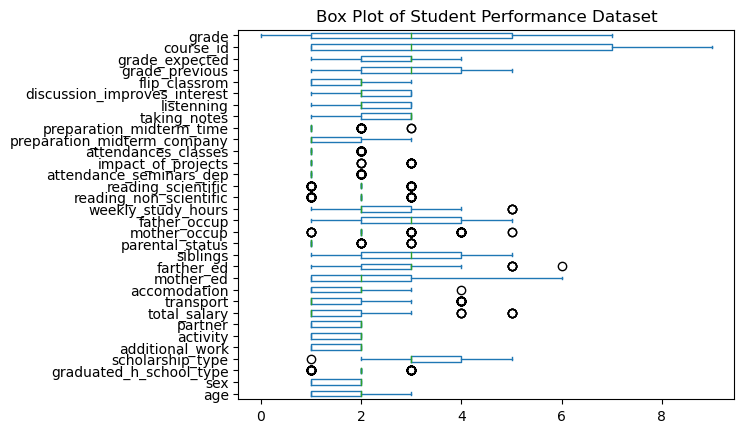

In [43]:
# creating box plots to show outliers in dataset
studentData.plot.box(vert=False, title="Box Plot of Student Performance Dataset")
plt.show()

Because very few outliers exist in the dataset, I will not be removing any outliers from the data. 
In addition, because this dataset has already been scaled, I will not be using any scaling techniques either. 

Here I am going to seperate the label value from the dataset and assign it to the variable 'y'.
I will assign the rest of the dataset to variable 'X'. 

In [44]:
# label values assigned to variable y
y= studentData['grade']

# all features besides dataset label assigned to variable X
X=studentData.drop(columns=['grade'])

Now, I am going to send my dataset without labels 'X' and label values 'y' to the function split_dataset. Both the test size and validate size values are going to be set at 21 instances. Here is the math: 

total instances = 144
30% of total instances = 43.2
15% for testing set and 15% for validation set = 21.6

I will round down and use only 21 dataset instances per the validation set and 21 instances for the testing set. 

In [45]:
# splits dataset into training, validation, and test sets
X_train, X_test, X_validate, y_train, y_test, y_validate = split_dataset(X, y, test_size=21, validate_size=21)

In addition, I am creating a PCA reduced dataset to use on all of the classifiers as well.

In [46]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [47]:
X_train_rdc, X_test_rdc, X_validate_rdc, y_train_rdc, y_test_rdc, y_validate_rdc = split_dataset(X_reduced, y, test_size=21, validate_size=21)

After splitting the data into training, validation, and testing sets, I will check to make sure they are the correct sizes

In [48]:
# size of training set 
X_train.shape

(103, 31)

In [49]:
# size of validation set
X_validate.shape

(21, 31)

In [50]:
# size of test set
X_test.shape

(21, 31)

## Training and Testing of individual classifiers

As stated before, I will be using the same classifiers here that I used with the MNIST dataset so that I can compare the ensemble classifier performances on different datasets.

### Stochastic Gradient Descent (SGD) Classifier

##### Non Reduced Dataset

Here I am declaring a new SGD Classifier and training it with the non reduced data.

In [51]:
# creation and training of SDG Classifier
sgd_clf2 = SGDClassifier(random_state=27, loss='modified_huber')
sgd_clf2 = train_clf(sgd_clf2, X_train, y_train)

SGDClassifier training time: 0.005003690719604492


Now testing with the validation set

In [52]:
# testing of SDG Classifier
sgd_results2 = test_clf(sgd_clf2, X_validate, y_validate)
print(sgd_clf2.__class__.__name__, "score: ", sgd_results2)

SGDClassifier score:  0.09523809523809523


Not great results. I am going to try again with the reduced dataset 

##### Reduced Dataset

In [53]:
# creation and training of SDG Classifier
sgd_clf2_rdc = SGDClassifier(random_state=27, loss='modified_huber')
sgd_clf2_rdc = train_clf(sgd_clf2, X_train_rdc, y_train_rdc)

SGDClassifier training time: 0.0040035247802734375


In [54]:
# testing of SDG Classifier
sgd_rdc_results2 =test_clf(sgd_clf2_rdc, X_validate_rdc, y_validate_rdc)
print(sgd_clf2_rdc.__class__.__name__, "score: ", sgd_rdc_results2)

SGDClassifier score:  0.19047619047619047


Very interesting. While I still have very poor performance, the reduced data set twice as accurate as the non reduced set

### KNeighbors Classifier

Here I am creating a new KNeighbors Classifier to train and test with the non reduced set 

##### Non Reduced Dataset

In [55]:
# creation and training of KNeighbors Classifier 
knn_clf2 = KNeighborsClassifier()
knn_clf2 = train_clf(knn_clf2, X_train, y_train)

KNeighborsClassifier training time: 0.002001523971557617


In [56]:
# testing of KNeighbors Classifier 
knn_result2 = test_clf(knn_clf2, X_validate, y_validate)
print(knn_clf2.__class__.__name__, "score: ", knn_result2)

KNeighborsClassifier score:  0.19047619047619047


Still very poor results. I will try again with the non reduced dataset

##### Reduced Dataset

In [57]:
# creation and training of KNeighbors Classifier with reduced dataset 
knn_clf2_rdc = KNeighborsClassifier()
knn_clf2_rdc = train_clf(knn_clf2_rdc, X_train_rdc, y_train_rdc)

KNeighborsClassifier training time: 0.0005614757537841797


In [58]:
# testing of KNeighbors Classifier with reduced dataset 
knn_rdc_result2 = test_clf(knn_clf2_rdc, X_validate_rdc, y_validate_rdc)
print(knn_clf2_rdc.__class__.__name__, "score: ", knn_rdc_result2)

KNeighborsClassifier score:  0.14285714285714285


I lost 5% accuracy here from using this dataset. Let's see how Extra Trees does next.

### Extra Trees Classifier

Here I will train and test a new Extra Trees Classifier with the non reduced dataset

##### Non Reduced Dataset

In [59]:
# creation and training of Extra Trees Classifier 
extr_clf2 = ExtraTreesClassifier(random_state=42)
extr_clf2 = train_clf(extr_clf2, X_train, y_train)

ExtraTreesClassifier training time: 0.07606840133666992


In [60]:
# testing of Extra Tree classifier
extr_result2 = test_clf(extr_clf2, X_validate, y_validate)
print(extr_clf.__class__.__name__, "score: ", extr_result2)

ExtraTreesClassifier score:  0.23809523809523808


Not great performance here. Let's see how well Extra trees does with the reduced dataset 

##### Reduced Dataset

In [61]:
# creation and training of Extra Trees Classifier with reduced dataset 
extr_clf2_rdc = ExtraTreesClassifier(random_state=42)
extr_clf2_rdc = train_clf(extr_clf2_rdc, X_train_rdc, y_train_rdc)

ExtraTreesClassifier training time: 0.07006359100341797


In [62]:
# testing of Extra Tree classifier with reduced dataset
extr_rdc_result2 = test_clf(extr_clf2_rdc, X_validate_rdc, y_validate_rdc)
print(extr_clf_rdc.__class__.__name__, "score: ", extr_rdc_result2)

ExtraTreesClassifier score:  0.23809523809523808


Looks like I did not get a performance drop using the reduced dataset. 

Since I am getting a slightly better net performance benefit from using the PCA reduced dataset, I will use the reduced dataset for my voting classifier.

### Voting Classifier (hard)

Here I am creating a new Voting Classifier with its voting setting set to hard. Like I mentioned before, I will be using the reduced dataset for both training and testing here.

In [63]:
# creation of new classifiers used for Voting Classifier
sgd_clf_hard2 = SGDClassifier(random_state=27, loss='modified_huber')
knnV_clf_hard2 = KNeighborsClassifier()
extrV_clf_hard2 = ExtraTreesClassifier(random_state=42)

# creation and training of Voting Classifier using SDG, KNeighbors, and Extra Trees
# voting setting set to hard
hard_voting_clf2 = VotingClassifier(
    estimators=[('sgd', sgd_clf_hard2),('kn', knnV_clf_hard2), ('et', extrV_clf_hard2)],
    voting='hard')

# training of the hard Voting Classifier
hard_voting_clf2 = train_clf(hard_voting_clf, X_train_rdc, y_train_rdc)

VotingClassifier training time: 0.10009050369262695


In [64]:
# testing of Hard Voting Classifier and printing result
hard_voting_result2 = test_clf(hard_voting_clf2, X_validate_rdc, y_validate_rdc)
print(hard_voting_clf.__class__.__name__, "score: ", hard_voting_result2)

VotingClassifier score:  0.23809523809523808


This score ties with the Extra Trees on the validation set. Next I am going to try with soft voting.

### Voting Classifier (soft)

In [65]:
# creation of new classifiers used for Voting Classifier
sgd_clf_soft2 = SGDClassifier(random_state=27, loss='modified_huber')
knnV_clf_soft2 = KNeighborsClassifier()
extr_clf_soft2 = ExtraTreesClassifier(random_state=42)


#  creation of voting classifier with soft voting setting
soft_voting_clf2 = VotingClassifier(
    estimators=[('sgd', sgd_clf_soft2),('kn', knnV_clf_soft2), ('et', extr_clf_soft2)],
    voting='soft')

# training soft voting classifier with reduced dataset
soft_voting_clf2 = train_clf(soft_voting_clf2, X_train_rdc, y_train_rdc)

VotingClassifier training time: 0.07506895065307617


In [66]:
# testing of Hard Voting Classifier and printing result
soft_voting_result2 = test_clf(soft_voting_clf2, X_validate_rdc, y_validate_rdc)
print(hard_voting_clf.__class__.__name__, "score: ", soft_voting_result2)

VotingClassifier score:  0.19047619047619047


It appears that hard voting is outperforming the soft Voting Classifier here. I will move on to use the hard Voting Classifier for my final test.

## Final tests of all classifiers on the Student Performance Dataset 

In [67]:
# final test using reduced dataset
sgd_final3 = test_clf(sgd_clf2_rdc, X_test_rdc, y_test_rdc)
knn_final3 = test_clf(knn_clf2_rdc, X_test_rdc, y_test_rdc)
extr_final3 = test_clf(extr_clf2_rdc, X_test_rdc, y_test_rdc)
hard_voting_final3 = test_clf(hard_voting_clf2, X_test_rdc, y_test_rdc)

In [68]:
print(sgd_clf.__class__.__name__, "score: ", sgd_final3)
print(knn_clf.__class__.__name__, "score: ", knn_final3)
print(extr_clf.__class__.__name__, "score: ", extr_final3)
print(soft_voting_clf.__class__.__name__, "score: ", hard_voting_final3)

SGDClassifier score:  0.14285714285714285
KNeighborsClassifier score:  0.19047619047619047
ExtraTreesClassifier score:  0.23809523809523808
VotingClassifier score:  0.14285714285714285


Well, this was unexpected. I lost a lot of performance of my voting classifier in my final test and Extra Trees beat me here. 

I am curious to see how much the dataset features correlate to each other 

In [69]:
studentData.corr()

,age,sex,graduated_h_school_type,scholarship_type,additional_work,activity,partner,total_salary,transport,accomodation,...,preparation_midterm_company,preparation_midterm_time,taking_notes,listenning,discussion_improves_interest,flip_classrom,grade_previous,grade_expected,course_id,grade
age,1.000000,0.138233,0.294426,-0.316506,-0.181019,0.138233,0.042572,0.127853,0.001472,-0.199257,...,-0.044462,0.030595,-0.181121,0.235576,-0.100812,0.228884,0.172597,0.121441,-0.304994,-0.095251
sex,0.138233,1.000000,0.126218,-0.206876,0.190476,0.224138,-0.125471,-0.022154,-0.013313,-0.154957,...,-0.032164,-0.013833,0.065013,-0.184238,0.065449,0.223095,0.241033,0.292842,-0.430704,0.335533
graduated_h_school_type,0.294426,0.126218,1.000000,-0.086965,-0.155331,0.073627,0.016557,-0.126440,0.023944,-0.018990,...,-0.027258,-0.053034,0.053969,0.123405,-0.082461,0.055107,0.019802,0.053497,-0.118761,0.104821
scholarship_type,-0.316506,-0.206876,-0.086965,1.000000,0.055351,-0.154281,0.120346,-0.119024,0.028288,0.036543,...,0.027357,0.005529,0.164447,0.018147,0.147922,-0.095411,0.236460,0.243517,0.317563,0.023963
additional_work,-0.181019,0.190476,-0.155331,0.055351,1.000000,0.220238,0.100010,-0.118284,0.102223,-0.152641,...,-0.153273,-0.246770,-0.033757,-0.158217,0.078973,0.027762,0.034666,0.007706,-0.114794,0.167445
activity,0.138233,0.224138,0.073627,-0.154281,0.220238,1.000000,-0.011406,0.060922,0.026626,-0.227030,...,-0.124062,-0.117580,-0.035007,0.004187,-0.028050,0.135949,0.002171,-0.092476,-0.326711,-0.062993
partner,0.042572,-0.125471,0.016557,0.120346,0.100010,-0.011406,1.000000,-0.078556,0.037811,-0.168201,...,-0.191197,-0.031005,0.005818,-0.054734,-0.000480,-0.082664,-0.058479,-0.012658,0.068769,-0.051778
total_salary,0.127853,-0.022154,-0.126440,-0.119024,-0.118284,0.060922,-0.078556,1.000000,-0.015926,0.030177,...,0.213079,0.048955,-0.235900,-0.050648,-0.031225,-0.037184,-0.100950,-0.058644,-0.123024,-0.166352
transport,0.001472,-0.013313,0.023944,0.028288,0.102223,0.026626,0.037811,-0.015926,1.000000,0.327283,...,-0.015048,-0.094471,0.022769,-0.019064,-0.134057,-0.158432,-0.036078,0.005909,0.114839,-0.156289
accomodation,-0.199257,-0.154957,-0.018990,0.036543,-0.152641,-0.227030,-0.168201,0.030177,0.327283,1.000000,...,0.132236,0.009870,0.066609,0.146396,-0.024462,-0.136949,-0.082775,-0.007332,0.271997,0.023683


It appears that this dataset's features do not correlate to each other very well. This may be the reason the algorthims had a difficult time on this dataset.